### :
    数据集分为训练集合测试集。
    两个数据集都包括每栋房子的特征，这些特征值有连续的数字、离散的标签甚至是缺失值“na”。
    其中，只有训练集包含房子的价格，即标签

In [90]:
import torch
import matplotlib.pyplot as plt
import pandas as pd
import sys
import numpy as np

In [91]:
train_data = pd.read_csv('./data/kaggle_house/train.csv')
test_data = pd.read_csv('./data/kaggle_house/test.csv')

In [92]:
train_data.shape # 训练集包括 1460 个样本，80 个特征， 1 个标签

(1460, 81)

In [93]:
test_data.shape # 测试集包括 1460 个样本，80 个特征

(1459, 80)

In [94]:
# 查看前4个样本的前4个特征、后2个特征和标签
train_data.iloc[:4,[0,1,2,3,-3,-2,-1]]

,Id,MSSubClass,MSZoning,LotFrontage,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,WD,Normal,208500
1,2,20,RL,80.0,WD,Normal,181500
2,3,60,RL,68.0,WD,Normal,223500
3,4,70,RL,60.0,WD,Abnorml,140000


In [95]:
# 第一个特征是Id,用于帮助模型记住每个训练样本,所以不使用它来训练
# 将所有的训练数据和测试数据的 79 个特征按样本连结
all_features = pd.concat([train_data.iloc[:,1:-1],test_data.iloc[:,1:]],axis=0)

In [96]:
all_features

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,160,RM,21.0,1936,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,6,2006,WD,Normal
1455,160,RM,21.0,1894,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,4,2006,WD,Abnorml
1456,20,RL,160.0,20000,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,9,2006,WD,Abnorml
1457,85,RL,62.0,10441,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,MnPrv,Shed,700,7,2006,WD,Normal


#### 预处理数据
    对连续数值的特征做标准化处理，对于缺失的特征值，我们将其替换成该特征的均值
![standardization](./img/3.12/standardization.png)

    将离散数值转成指示特征,用 0/1 表示

In [97]:
number_features = all_features.dtypes[all_features.dtypes != 'object'].index # 筛选数值列
all_features[number_features] = all_features[number_features].apply(
    lambda x : (x - x.mean()) / (x.std())
)
# 标准化后，每个数值特征的均值变为0，所以可以直接用0来替换缺失值
all_features[number_features] = all_features[number_features].fillna(value=0)

In [98]:
# dummy_na=True 将缺失值也当作合法的特征值并为其创建指示特征
all_features = pd.get_dummies(all_features,dummy_na=True)
all_features.shape # [2919,79] => [2919,331]

(2919, 331)

In [99]:
all_features.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,SaleType_Oth,SaleType_WD,SaleType_nan,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,SaleCondition_nan
0,0.067320,-0.184443,-0.217841,0.646073,-0.507197,1.046078,0.896679,0.523038,0.580708,-0.29303,...,0,1,0,0,0,0,0,1,0,0
1,-0.873466,0.458096,-0.072032,-0.063174,2.187904,0.154737,-0.395536,-0.569893,1.177709,-0.29303,...,0,1,0,0,0,0,0,1,0,0
2,0.067320,-0.055935,0.137173,0.646073,-0.507197,0.980053,0.848819,0.333448,0.097840,-0.29303,...,0,1,0,0,0,0,0,1,0,0
3,0.302516,-0.398622,-0.078371,0.646073,-0.507197,-1.859033,-0.682695,-0.569893,-0.494771,-0.29303,...,0,1,0,1,0,0,0,0,0,0
4,0.067320,0.629439,0.518814,1.355319,-0.507197,0.947040,0.753100,1.381770,0.468770,-0.29303,...,0,1,0,0,0,0,0,1,0,0


In [100]:
# 通过values属性得到NumPy格式的数据,并转成Tensor方便后面的训练
n_train = train_data.shape[0]
train_features = torch.tensor(all_features[:n_train].values,dtype=torch.float)
test_features = torch.tensor(all_features[n_train:].values,dtype=torch.float)
train_labels = torch.tensor(train_data['SalePrice'].values,dtype=torch.float).view(-1,1)
train_features.shape,test_features.shape,train_labels.shape

(torch.Size([1460, 331]), torch.Size([1459, 331]), torch.Size([1460, 1]))

#### 训练模型:
    使用一个基本的线性回归模型和平方损失函数来训练模型

In [101]:
loss_fn = torch.nn.MSELoss()

def get_net(feature_num):
    net = torch.nn.Linear(feature_num,1)
    for param in net.parameters():
        torch.nn.init.normal_(param,mean=0,std=0.01)
        
    return net

#### 比赛用来评价模型的对数均方根误差:
![eval_loss](./img/3.12/eval_loss.png)

In [102]:
def log_rmse(net,features,labels):
    with torch.no_grad():
        y_hat = net(features)
        # 将小于1的值设成1，使得取对数时数值更稳定
        clipped_preds = torch.max(y_hat,torch.tensor(1.0))
        rmse = torch.sqrt(loss_fn(clipped_preds.log(),labels.log()))
        
    return rmse.item()

In [103]:
# 使用了Adam优化算法
def train(net,train_features,train_labels,test_features,test_labels,num_epochs,lr,wd,batch_size):
    train_ls,test_ls = [],[]
    dataset = torch.utils.data.TensorDataset(train_features,train_labels)
    train_iter = torch.utils.data.DataLoader(dataset,batch_size,shuffle=True)
    
    optimizer = torch.optim.Adam(net.parameters(),lr,weight_decay=wd)
#     net = net.float()
    
    for epoch in range(num_epochs):
        for x,y in train_iter:
            y_hat = net(x)
            loss = loss_fn(y_hat,y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
        train_ls.append(log_rmse(net,train_features,train_labels))
        if test_labels is not None:
            test_ls.append(log_rmse(net,test_features,test_labels))
            
    return train_ls,test_ls

#### K 折交叉验证:

In [104]:
def get_k_fold_data(k,i,x,y):
    # 返回第i折交叉验证时所需要的训练和验证数据
    assert k > 1
    fold_size = x.shape[0] // k # 取整数
    x_train,y_train = None,None
    for j in range(k):
        idx = slice(j * fold_size,(j + 1) * fold_size) # 3折时, slice(0, 3, None) slice(3, 6, None) slice(6, 9, None)
        x_part,y_part = x[idx,:],y[idx]
        if j == i:
            x_valid,y_valid = x_part,y_part
        elif x_train is None:
            x_train,y_train = x_part,y_part
        else:
            x_train = torch.cat([x_train,x_part],dim=0)
            y_train = torch.cat([y_train,y_part],dim=0)
    
    return x_train,y_train,x_valid,y_valid

In [116]:
def semilogy(x_vals, y_vals, x_label, y_label, x2_vals=None, y2_vals=None,
             legend=None, figsize=(20,8)):
    plt.figure(figsize=figsize)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.semilogy(x_vals, y_vals)
    if x2_vals and y2_vals:
        plt.semilogy(x2_vals, y2_vals, linestyle=':')
        plt.legend(legend)

In [117]:
def k_fold(k,x_train,y_train,num_epochs,lr,wd,batch_size):
    train_l_sum,val_l_sum = 0,0
    
    for i in range(k):
        data = get_k_fold_data(k,i,x_train,y_train)
        net = get_net(x_train.shape[1])
        train_ls,valid_ls = train(net,*data,num_epochs,lr,wd,batch_size)
        
        train_l_sum += train_ls[-1]
        val_l_sum += valid_ls[-1]
        
        if i == 0:
            semilogy(range(1, num_epochs + 1), train_ls, 'epochs', 'rmse',
                         range(1, num_epochs + 1), valid_ls,
                         ['train', 'valid'])
        print('fold %d, train rmse %f, valid rmse %f' % (i + 1, train_ls[-1], valid_ls[-1]))
        
    return train_l_sum / k,val_l_sum / k

fold 1, train rmse 0.170714, valid rmse 0.157168
fold 2, train rmse 0.161957, valid rmse 0.188935
fold 3, train rmse 0.164008, valid rmse 0.168587
fold 4, train rmse 0.168984, valid rmse 0.154969
fold 5, train rmse 0.163536, valid rmse 0.183255


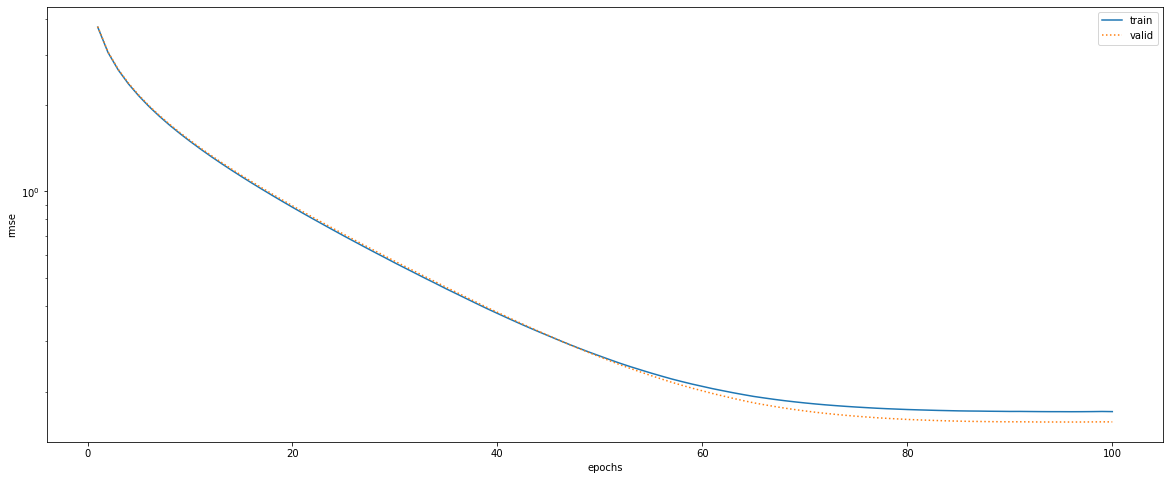

In [118]:
k, num_epochs, lr, weight_decay, batch_size = 5, 100, 5, 0, 64
train_l,val_l = k_fold(k,train_features,train_labels,num_epochs,lr,weight_decay,batch_size)

#### 预测并在Kaggle提交结果

In [133]:
def train_and_pred(train_features,test_features,train_labels,test_data,num_epochs,lr,wd,batch_size):
    net = get_net(train_features.shape[1])
    train_ls,_ = train(net,train_features,train_labels,None,None,num_epochs,lr,wd,batch_size)
    semilogy(range(1,num_epochs+1),train_ls,'epoch','rmse')
    print('train rmse %f' % train_ls[-1])
    
    preds = net(test_features).detach().numpy()
    test_data['SalePrice'] = pd.Series(preds.reshape(1,-1)[0])
    submission = pd.concat([test_data['Id'], test_data['SalePrice']], axis=1)
    submission.to_csv('./submission.csv', index=False)

train rmse 0.162464


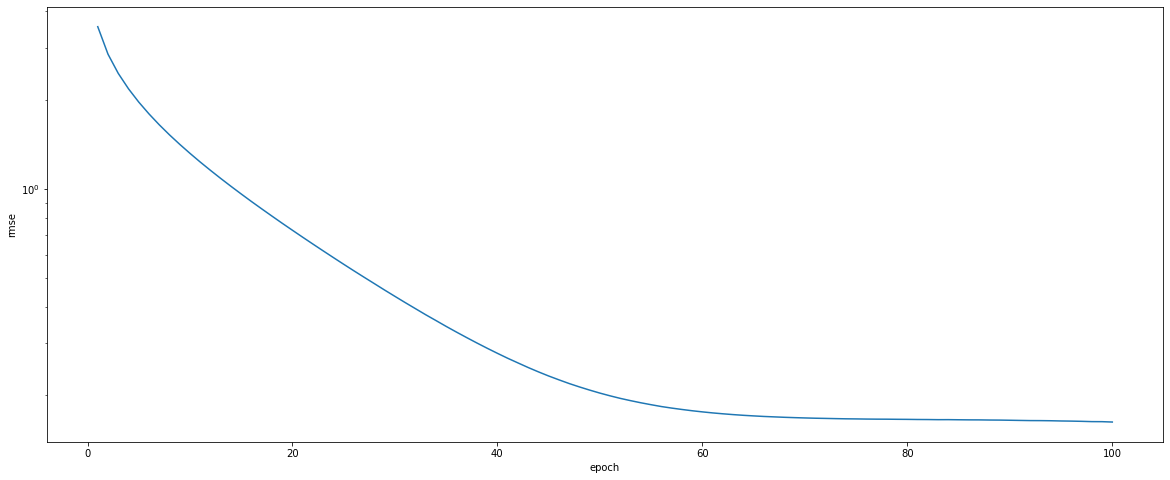

In [134]:
train_and_pred(train_features, test_features, train_labels, test_data, num_epochs, lr, weight_decay, batch_size)

#### K折交叉验证的简单方法：

In [119]:
from sklearn.model_selection import KFold

In [120]:
x = torch.tensor(np.arange(0,10,0.5)).view(-1,2)
x

tensor([[0.0000, 0.5000],
        [1.0000, 1.5000],
        [2.0000, 2.5000],
        [3.0000, 3.5000],
        [4.0000, 4.5000],
        [5.0000, 5.5000],
        [6.0000, 6.5000],
        [7.0000, 7.5000],
        [8.0000, 8.5000],
        [9.0000, 9.5000]], dtype=torch.float64)

In [121]:
y = torch.tensor(np.ones(x.shape[0]))
y

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], dtype=torch.float64)

In [126]:
k = KFold(2)

In [127]:
idx = k.get_n_splits(x,y) # 返回分的块数
idx

2

In [132]:
for train_idx,val_idx in k.split(x,y): # 返回分类后数据集的index
    print('train_idx:',train_idx)
    print('val_idx:',val_idx)
    x_train,x_val = x[train_idx],x[val_idx]
    y_train,y_val = y[train_idx],y[val_idx]

train_idx: [5 6 7 8 9]
val_idx: [0 1 2 3 4]
train_idx: [0 1 2 3 4]
val_idx: [5 6 7 8 9]


### 总结:
    真实数据通常混合了不同的数据类型，需要进行预处理
        常用的预处理方法：将实值数据重新缩放为零均值和单位方法；用均值替换缺失值
    将类别特征转化为指标特征，可以使我们把这个特征当作一个独热向量来对待
    使用 K 折交叉验证来选择模型并调整超参数